In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from fastai.vision import *
from fastai import *
from fastai.data_block import _maybe_squeeze
from efficientnet_pytorch import EfficientNet

In [3]:
#export
path = Path('/home/jupyter/rsns/data/preprocessed')


In [4]:
#export
df_train = pd.read_csv(path/'train_seed42.csv')

In [5]:
#export
# Radek's monkey patch to work out NAN in pandas
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

ItemList.label_from_df = modified_label_from_df

In [6]:
#export
tfms = get_transforms(flip_vert=True,  max_warp=0., max_rotate=60., max_zoom=1.1,p_lighting=0.)
bs = 64
sz = 128

In [8]:
path.ls()

[PosixPath('/home/jupyter/rsns/data/preprocessed/models'),
 PosixPath('/home/jupyter/rsns/data/preprocessed/train_seed42.csv'),
 PosixPath('/home/jupyter/rsns/data/preprocessed/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/rsns/data/preprocessed/full_train_jpg'),
 PosixPath('/home/jupyter/rsns/data/preprocessed/224')]

In [18]:
df_train.head()

,fn,labels,PatientID,is_valid
0,ID_63eb1e259.jpg,NaN,ID_63eb1e259,True
1,ID_2669954a7.jpg,NaN,ID_2669954a7,False
2,ID_52c9913b1.jpg,NaN,ID_52c9913b1,True
3,ID_4e6ff6126.jpg,NaN,ID_4e6ff6126,True
4,ID_7858edd88.jpg,NaN,ID_7858edd88,True


In [7]:
data = (ImageList
        .from_csv(path,'train_seed42.csv',folder='full_train_jpg')
        .split_from_df(col='is_valid')
        .label_from_df(label_delim=' ')
        .transform(tfms,size=(sz,sz))
        #.add_test(str(path) + '/preprocessed/224/test/' + test_fns)
        .databunch(bs=bs,num_workers=16)
        .normalize(imagenet_stats)
       )

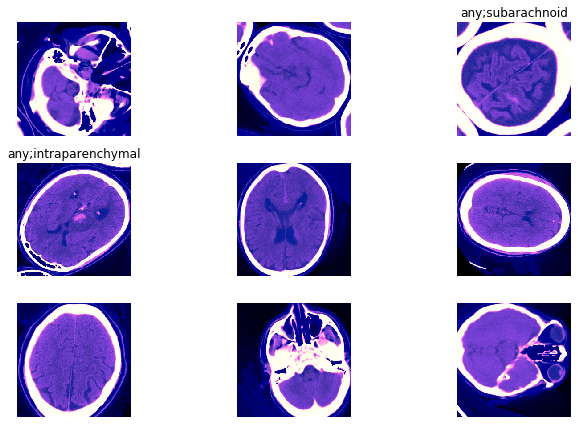

In [27]:
data.show_batch(rows=3,figsize=(10,6))

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

Loaded pretrained weights for efficientnet-b0


In [9]:
loss_weights = torch.FloatTensor([2,1,1,1,1,1]).cuda()
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)

In [10]:
learn = Learner(data,model,metrics=[accuracy_thresh],loss_func=loss_func, model_dir=path/'models/eff_net').to_fp16()

In [11]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.32E-03


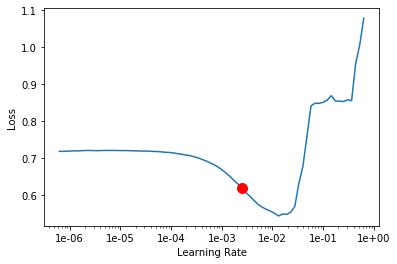

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
from fastai.callbacks import SaveModelCallback#,EarlyStoppingCallback

In [ ]:
lr = 1e-3
learn.fit_one_cycle(5,lr,callbacks=[
                                    SaveModelCallback(learn,every='epoch',name='effb4-v2-256')
                                   ])

epoch,train_loss,valid_loss,accuracy_thresh,time
